# Week 11: Laboratory 10

<font size="6"> Motion Tracking </font> <br>
<font size="3"> Last updated June 16, 2022 </font>

## <span style="color:orange;"> 00. Content </span>

<font size="5"> Mathematics </font>
- Taylor series
- Vector fields
- Polar coordinates
    
<font size="5"> Programming Skills </font>
- Array functions 
- File I/O 
    
<font size="5"> Embedded Systems </font>
- Thonny and MicroPython

## <span style="color:orange;"> 0. Required Hardware </span>
- Microcontroller: Raspberry Pi Pico
- Breadboard
- USB connector
- Camera

<h3 style="background-color:lightblue"> Write your name and email below: </h3>

**Name:** me 

**Email:** me @purdue.edu

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Reading in Video with OpenCV

In this lab, we will be using a new Python library called OpenCV. From the [official documentation](https://docs.opencv.org/4.x/d1/dfb/intro.html), "OpenCV is an open-source library that includes several hundreds of computer vision algorithms." Today, we will mostly be using it to read and display modified video frames, and we will be doing the "vision" in computer vision manually with our own functions.

Run the following cell to read in the video file. Using `vid.read()`, returns two values: the Boolean varible `success`, which is `True` if the frame was read without any errors, and `frame` which is as it sounds the image that is captured from the video. The camera hardware you will connect to your Pico can only return grayscale images, so we are converting each frame to grayscale using the function `cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)`. For speed in later computations, it is helpful to reduce the frame size. Here, we've scaled down each frame by a factor of 4.

Running the cell will cause a separate window to pop up, displaying the smaller, grayscale video. After reading in the whole video, the separate window will close automatically or you can override this by pressing the "Q" key on your keyboard.

In [143]:
vid = cv2.VideoCapture('test_vid.MOV') # from YT: Different Bouncing Ball References
height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
width  = vid.get(cv2.CAP_PROP_FRAME_WIDTH) 
scale = 0.25
new_size = (int(width*scale),int(height*scale))

while vid.isOpened():
    success, frame = vid.read()
    if not success:
        print("Unable to read frame. Exiting ...")
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame,dsize=new_size)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'): # press Q on keyboard to stop
        break
vid.release()
cv2.destroyAllWindows()

Unable to read frame. Exiting ...


## Optical Flow & Motion Tracking

Optical flow is the motion and light patterns observed when an object and camera move relative to each other. The velocity of objects in a video can be estimated using optical flow. This is espeically relevant in computer vision tasks when the goal is motion-based object detection or robot navigation.

Let $f(x,y,t)$ be a continuous grayscale video mapping $\mathbb{R}^3$ to $\mathbb{R}$.
The variables $x$ and $y$ represent pixel coordinates and $t$ is the frame number.
The output is the pixel intensity, a integer between $0$ and $255$, at location $(x,y)$ in frame $t$.
When we read in an image in Python we are observing a sampling of points of $f(x,y,t)$ which we will call $f_d(n,m,t)$.
So, $
    f_d(n,m,t) = f(n\Delta i, m \Delta j,t).$
where $\Delta i$ and $\Delta j$ are the sampling distances along the x and y-axis, respectively.

Let's assume there is a object at the location $(x,y,t)$ and after a small $\Delta t$ step forward in time, the object moves from $(x,y)$ to $(x+\Delta x,y+\Delta y)$ in the video.
Using Taylor series to expand $f(x,y,t)$ and truncating after the first degree terms, we can estimate the velocity of the object.
$$ 
f(x+\Delta x,y+\Delta y,t+\Delta t) \approx f(x,y,t) +
    \frac{\partial f}{dx}\Delta x + 
    \frac{\partial f}{dy}\Delta y + 
    \frac{\partial f}{dt}\Delta t 
$$
Assuming the object's brightness do not change as it moves, $f(x+\Delta x,y+\Delta y,t+\Delta t)=f(x,y,t)$, so 
$$  \frac{\partial f}{dx}\Delta x + 
    \frac{\partial f}{dy}\Delta y + 
    \frac{\partial f}{dt}\Delta t = 0
$$
Divide both sides by $\Delta t$ to get
$$  \frac{\partial f}{dx} \frac{\Delta x}{\Delta t} + 
    \frac{\partial f}{dy} \frac{\Delta y}{\Delta t} + 
    \frac{\partial f}{dt} = 0
$$
Notice that $\frac{\partial f}{dx}$ and $\frac{\partial f}{dy}$ are the image gradients we calculated in the lab on edge detection, and $\frac{\partial f}{dt}$ is the pixel-wise difference between frame $t+\Delta t$ and frame $t$.
That means in the last equation the velocity components $\frac{\Delta x}{\Delta t}$ and $\frac{\Delta y}{\Delta t}$ are unknown and the other 3 terms $\frac{\partial f}{dx},\frac{\partial f}{dy},$ and  $\frac{\partial f}{dt}$ we can calculate, but we can't solve for 2 unknowns with only one equation. We're going to need some more assumptions.

### <span style="color:red"> Exercise </span>

Look up "the aperature problem" as it relates to optical flow. In a few sentences, describe what it is and how it impacts the type of objects we are able to track with optical flow. 

<h3 style="background-color:lightblue"> Write Answers for Exercise Below </h3>

## Farneback Optimal Flow

The assumption that $f(x+\Delta x,y+\Delta y,t+\Delta t)=f(x,y,t)$ is reasonable for most situations. However, if there is a lot of change from frame to frame, for example a helicopter-mounted camera undergoing strong vibrations, then our results will not be as good. In 2003, Gunnar Farneback proposed a solution to this problem. To fully explain his method, a good knowlegde of linear algebra and least squares minimization is necessary, but we will give a general overview. 

The idea behind Farneback's algorithm for calculating optimal flow is:
- Starting with the previous frame, reduce the resolution of the image.
- Estimate the values of a small patch of pixels with a quadratic polynomial (like how we did polynomial interpolation in 1 dimension but this is in 2 dimensions).
- In the next frame, do the same quadratic estimation.
- With the 2 simplified quadratic functions, it's "easy" to calculate the displacement of the patch of pixels (this is where the linear algebra and least squares minimization comes into play).
- Increase the resolution of the frame and repeat the process again. 

By repeating on higher and higher resolution images, we are able to capture both big and small displacements. After refining how much displacement there is between the two frames, the result is $\frac{\Delta x}{\Delta t}$ and $\frac{\Delta y}{\Delta t}$ for each pixel in the image, so we call this type of process dense optimal flow. 

### <span style="color:red"> Exercise </span>

Read through the following cell. Describe what each line of code does. It is okay to add comments in the cell but make sure the comments are not so long to where you need to scroll horizontally to read one line. 

<h3 style="background-color:lightblue"> Write Answers for Exercise Below </h3>

In [6]:
vid = cv2.VideoCapture('test_vid.MOV')
height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
width  = vid.get(cv2.CAP_PROP_FRAME_WIDTH) 
scale = 0.25
new_size = (int(width*scale),int(height*scale))

success, frame1 = vid.read()
frame1 = cv2.resize(frame1,dsize=new_size)
previous = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)

while True:
    success, frame2 = vid.read()
    if not success:
        print("Unable to read frame. Exiting ...")
        break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    next = cv2.resize(next,dsize=new_size)
    
    # flow[i,j] = [dx/dt,dy/dt] for each pixel calculate optimal flow
    flow = cv2.calcOpticalFlowFarneback(previous,next, flow = None, 
                    pyr_scale = 0.5, 
                    levels = 3, 
                    winsize = 10, 
                    iterations = 3, 
                    poly_n = 5, 
                    poly_sigma = 1.1, flags = 0)
    cv2.imshow('next_frame',next)
    k = cv2.waitKey(30) & 0xff
    if k == ord('q'): # press Q on keyboard to stop
        break
    prvs = next

vid.release()
cv2.destroyAllWindows()

At each step `flow` defines a vector field. At pixel location $[i,j]$, we define a vector $\langle dx/dt, dy/dt\rangle$. This vector has a magnitude and a direction. 

### <span style="color:red"> Exercise </span>

1. What are the formulas to calculate the magnitute and direction of the vector $\langle x,y \rangle$?
2. Why would computing the magnitude and direction of $\langle x,y \rangle$ be the same as converting the Cartesian ordered pair $(x,y)$ to polar coordinates?

<h3 style="background-color:lightblue"> Write Answers for Exercise Below </h3>

### <span style="color:red"> Exercise </span>

Pick a two frames to calculate `flow`. Use the matplotlib function [quiver](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.quiver.html) to plot the vector field using arrows. 

<h3 style="background-color:lightblue"> Write Answers for Exercise Below </h3>

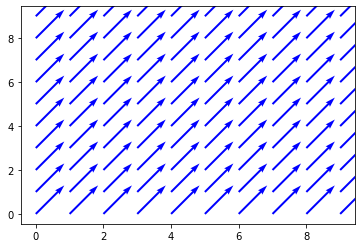

In [83]:
# example for a constant vector field
x,y = np.meshgrid(np.linspace(start=0, stop=10, num=10, endpoint=False), 
                   np.linspace(start=0, stop=10, num=10 , endpoint=False))
dxdt = 1
dydt = 1
plt.quiver(x,y,dxdt,dydt,color='b', units='xy', scale=1)
plt.show()

In [ ]:
# solution
x, y = np.meshgrid(np.linspace(0, flow.shape[1], flow.shape[1], endpoint=False), 
                   np.linspace(0, flow.shape[0], flow.shape[0], endpoint=False))
plt.quiver(x,y,flow[:,:,0], flow[:,:,1],
            color='b', units='xy', scale=5)
plt.show()

Another way to visualize the vector field is using color to represent angles and the brightness of the color to represent the magnitude. The HSV or (Hue Saturation Value) color space is the perfect candidate. We are going to relate Hue to the angle of the vector. The image shows each hue at full saturation for different angles.

<center>
<img src='hue_angle.jpg'>
<center\>

[src](https://sc.edu/study/colleges_schools/medicine/education/basic_science_departments/cell_biology_and_anatomy/index.php)

### <span style="color:red"> Exercise </span>

Fill in the code below to compute the magnitude and direction of the velocity vectors at each pixel location. Now we can visualize how the vector field changes from frame to frame and in what direction the objects in the frame are moving. 

<h3 style="background-color:lightblue"> Write Answers for Exercise Below </h3>

In [ ]:
cap = cv2.VideoCapture('test_vid.MOV')
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH) 
scale = 0.25

ret, frame1 = cap.read()
frame1 = cv2.resize(frame1,dsize=(int(width*scale),int(height*scale)))
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255 # always at full saturation

while True:
    ret, frame2 = cap.read()
    if not ret:
        print("Unable to read frame. Exiting ...")
        break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    next = cv2.resize(next,dsize=(int(width*scale),int(height*scale)))
    flow = cv2.calcOpticalFlowFarneback(prvs,next, flow = None, 
                    pyr_scale = 0.5, 
                    levels = 3, 
                    winsize = 10, 
                    iterations = 3, 
                    poly_n = 5, 
                    poly_sigma = 1.1, flags = 0)

    # compute magnitute and angle for each vector in flow
    # mag and ang should have the same dimensions as the variable next 
    mag = # fill in
    ang = # fill in

    hsv[...,0] = ang*180/np.pi # converts radians to degrees
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == ord('q'): # press Q on keyboard to stop
        break
    prvs = next

cap.release()
cv2.destroyAllWindows()

## Connecting the Camera

__add pictures and instructions for how to wire up the camera to the Pico__

### <span style="color:red"> Exercise </span>

1. With your camera set up, record a video of objects moving whether it be you, your neighbor, your hand, a pen, etc. Use Farneback's algorithm and our visualization method to display the optical flow.
1. Can you think of a (mathematical) rule to tell when an object enters the camera's view? (*Hint: thresholding*)

<h3 style="background-color:lightblue"> Write Answers for Exercise Below </h3>

## <span style="color:green"> Reflection </span>

__1. What parts of the lab, if any, do you feel you did well? <br>
2. What are some things you learned today? <br>
3. Are there any topics that could use more clarification? <br>
4. Do you have any suggestions on parts of the lab to improve?__

<h3 style="background-color:lightblue"> Write Answers for the Reflection Below </h3>